# Homework #7:
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 10/12/2019|
|Updated | 10/12/2019|

## 11.5 Monte Carlo

### 1. "Integrate"
First, let's generate some curves and a region for which we would like to calculate the area.

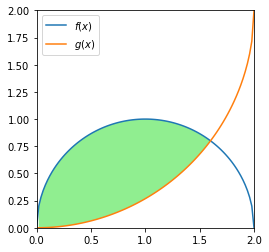

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return np.sqrt(1-(x-1)**2)
def g(x):
    return 2-np.sqrt(4-x**2)

x1 = np.linspace(0,2,100)
y1 = f(x1)
y2 = g(x1)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.plot(x1, y1, label="$f(x)$")
ax1.plot(x1, y2, label="$g(x)$")
ax1.legend(loc="upper left")
ax1.set_xlim(0,2)
ax1.set_ylim(0,2)
ax1.fill_between(x1, y1, y2, where=y1>y2, facecolor='lightgreen')
plt.show()

To calculate the area shaded in green using _Monte Carlo Integration_ we will:
- Generate a large number of $N$ random points in the bounded square.
- Count the number of points $k$ that fall inside the shaded region .
- If the probability is $P = k/N \approx I/A$, then $I \approx kA/N$

In [2]:
# Monte Carlo intergral
from random import random

def MC(N, f, g, x_start, x_end, y_start, y_end):
    """
    Calculate and return the area between two functions, f(x) and 
    g(x), using the Monte Carlo method, by generating N random points
    in the bounded rectange defined by a width (x_start and x_end)
    and a height (y_start, y_end)
    """
    width = x_end - x_start
    height = y_end - y_start
    count = 0
    
    for i in range(N):
        x = width*random() + x_start
        y = height*random() + y_start
        if y < f(x) and y > g(x):
            count += 1
    I = width*height*count/N
    
    return I

In [3]:
import time

timer_start = time.perf_counter() # start of timer
area = MC(int(1e7), f, g, 0, 2, 0, 2)
timer_end = time.perf_counter() # end timer
time = timer_end - timer_start

print("The area shaded in green is", area)
print("Time to calculate:", time, "seconds")

The area shaded in green is 0.9611308
Time to calculate: 16.29866889999903 seconds


In fact, for comparison, the exact, analytic solution to this definite integral is$^1$

$$ I = 2\arcsin\left(\frac{4}{5}\right) - 2 + \frac{\pi}{4} + \frac{1}{2}\arcsin\left(\frac{3}{5}\right), $$

which we can calculate as...

$^1$ See https://www.symbolab.com/solver/area-between-curves-calculator/area%20%5Csqrt%7B1-%5Cleft(x-1%5Cright)%5E%7B2%7D%7D%2C%202-%5Csqrt%7B4-x%5E%7B2%7D%7D%20

In [4]:
from math import pi

2*np.arcsin(4/5) - 2 + (pi/4) + (1/2)*np.arcsin(3/5)

0.961739153797315

### 2. Error Analysis
Let's now calculate the area many times (e.g., 100) for different values of $N$ (e.g., 100, 1000, 10,000, 100,000), collect the data and determine their variances.

In [5]:
def MCstats(N, f, g, x_start, x_end, y_start, y_end, runs, plot):
    """
    Repeatedly calculate an area using the Monte Carlo method, MC(),
    for as many "runs," compile the dataset and return its variance.
    """
    
    data = np.zeros(runs)
    
    for i in range(runs):
        data[i] = MC(N, f, g, x_start, x_end, y_start, y_end)
        
    title = "Statistics for " + str(runs) + " runs with $N =$" + str(N)
    
    if plot:
        plt.figure()
        plt.plot(data, ".")
        plt.title(title)
        plt.xlabel("Run No.")
        plt.ylabel("Calc'd Area")
        plt.ylim(0.5,1.5)
        plt.show()
    
    return np.var(data)

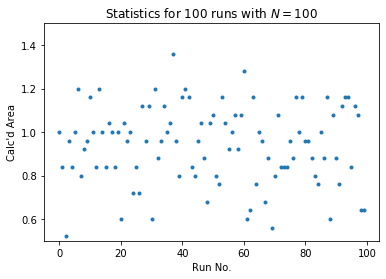

Variance: 0.031022560000000005


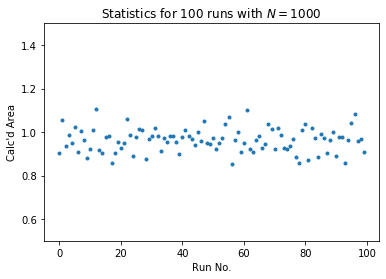

Variance: 0.002921374400000001


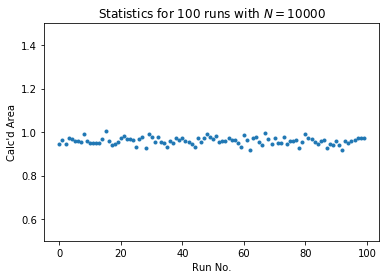

Variance: 0.0002798138239999998


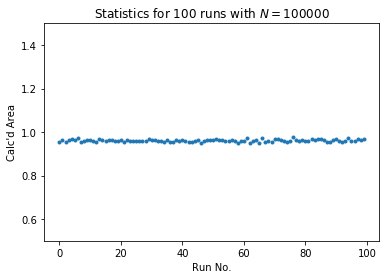

Variance: 3.058587200000003e-05


In [6]:
runs = 100
diff_Ns = [100, 1000, 10000, 100000]

for i in diff_Ns:
    print("Variance:", MCstats(i, f, g, 0, 2, 0, 2, runs, True))

As we might expect, the variance of the calculated area over multiple runs decreases as $N$ increases, corresponding to an improvement in accuracy.

## 12.4 Importance Sampling

### 1. Example
Using the importance sampling method, with $w(x) = x^{-1/2}$ and one million random points, let's calculate a value for the integral

$$ I = \int_0 ^1 \frac{x^{-1/2}}{e^x + 1} dx \tag{1}$$

First let's plot the integrand $f(x)$ and weighting function $w(x)$.

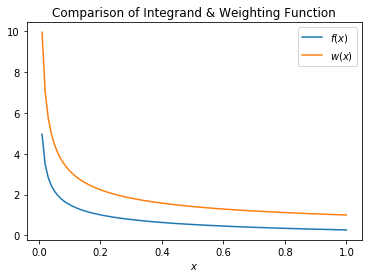

In [7]:
f = lambda x: 1/np.sqrt(x)/(np.exp(x)+1)
w = lambda x: 1/np.sqrt(x)

x = np.linspace(0,1,100)
plt.plot(x[1:], f(x[1:]), label='$f(x)$') # start w/ 2nd element 
plt.plot(x[1:], w(x[1:]), label='$w(x)$') # to avoid div. by 0
plt.title("Comparison of Integrand & Weighting Function")
plt.xlabel("$x$")
plt.legend()
plt.show()

Next, let's determine the probability function, defined as

$$
\begin{equation*}
    p(x) \equiv \frac{w(x)}{\int_a^b w(x)dx}.
    \tag{2}
\end{equation*}
$$

With $w(x) = x^{-1/2}$, evaluating the integral in the denominator, on the interval from $a=0$ to $b=1$, yields

$$
\begin{align}
    \int_a^b w(x)dx =& \int_0^1 x^{-1/2}dx \\
                =& 2x^{1/2} \big|_0^1 \\
                =& 2.
    \tag{3}
\end{align}
$$

Plugging Eq. 3 into 2 yields

$$
\begin{align}
    p(x) =& \frac{x^{-1/2}}{2}. \\
    \tag{4}
\end{align}
$$

Now, the cumulative distribution function $F(x)$ of the probability function $p(x)$ becomes

$$
\begin{align}
    F(x) \equiv& \int_0^x p(x)dx \\
              =& \int_0^x \frac{x^{-1/2}}{2} dx\\
              =& x^{1/2}\big|_0^x \\
              =& x^{1/2}.
    \tag{5}
\end{align}
$$

and its inverse,

$$
\begin{align}
     F^{-1}(x) =& x^2.        
    \tag{6}
\end{align}
$$

We finally can calculate the integral in Eq. 1 using the formula

$$ I \approx  \frac{1}{N} \sum_{i=1}^{N} \frac{f(x_i)}{w(x_i)} \int_a^b w(x)dx \tag{7},$$

by averaging $f(x)/w(x)$ in the points generated from $F^{-1}(x)$.

In [8]:
from scipy.integrate import quad

def IMC(f, w, F_inv, x_start, x_end, N):
    """
    Calculate and return the integral of 'f', on the interval
    'x_start' and 'x_end', using the Monte Carlo method with
    importance sampling, with weighting function 'w', inverse
    transform sampling function 'F_inv', and 'N' random points.
    """
    const = quad(w, x_start, x_end)[0]
    width = x_end - x_start
    I = 0
    
    for i in range(N):
        x = width*random() + x_start
        y = F_inv(x)
        I += f(y)/w(y)
        
    return I/N*const

In [9]:
F_inv = lambda x: x**2 # def inv transform sampling

print("I[0, 1] ≈", IMC(f, w, F_inv, 0, 1, int(1e6)))

I[0, 1] ≈ 0.8387511202359776


For comparison, we can calculate the integral using SciPy.

In [10]:
print("From SciPy: I =", quad(f, 0, 1)[0])

From SciPy: I = 0.8389329600133838


### 2. Harder Example
Using importance sampling, with $w(x) = 1/x$ and one million random points, let's calculate a value for the integral

$$ I = \int_0 ^1 \frac{x^{-1}}{e^x + 1} dx \tag{8} $$

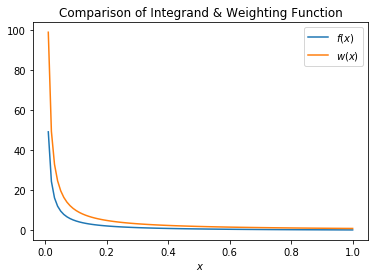

In [11]:
f = lambda x: 1/x/(np.exp(x)+1)
w = lambda x: 1/x

x = np.linspace(0,1,100)
plt.plot(x[1:], f(x[1:]), label='$f(x)$') # start w/ 2nd element 
plt.plot(x[1:], w(x[1:]), label='$w(x)$') # to avoid div. by 0
plt.title("Comparison of Integrand & Weighting Function")
plt.xlabel("$x$")
plt.legend()
plt.show()

Again, from Eq. 2,

$$
\begin{equation*}
    p(x) \equiv \frac{w(x)}{\int_a^b w(x)dx}.
\end{equation*}
$$

But this time, since $w(x) = x^{-1}$, the integral in the denominator is divergent:

$$
\begin{align}
    \int_a^b w(x)dx =& \int_0^1 x^{-1}dx \\
                =& \ln x \big|_0^1 \textrm{ (undefined)}.
    \tag{9}
\end{align}
$$

We can try approximating its value by using SciPy, using an initial bound very slightly above zero; e.g., let $a = 5.981 \times10^{-16}$.

In [12]:
a = 5.981e-16 # 5.981e-16 is the smallest value allowed by quad() for w
c = quad(w, a, 1)[0]
c

35.052773709842654

Thus, we'll take

$$
\begin{align}
    c = \int_a^1 w(x)dx \approx 35.052773709842654.
    \tag{10}
\end{align}
$$

Plugging Eq. 10 into 2 yields

$$
\begin{align}
    p(x) =& \frac{x^{-1}}{c}, \\
    \tag{11}
\end{align}
$$

with cumulative distribution function,

$$
\begin{align}
    F(x) =& \frac{1}{c}\int_a^x \frac{1}{x} dx \\
         =& \frac{1}{c} \ln x \big|_a^x \\
         =& \frac{1}{c}(\ln x - \ln a),
    \tag{12}
\end{align}
$$

and inverse

$$
\begin{align}
     F^{-1}(x) =& e^{(cx + \ln a)}.       
    \tag{13}
\end{align}
$$

In [13]:
from math import e, log

ln_a = log(a)
F_inv = lambda x: pow(e, (c*x+ln_a))

print("I[a, 1] ≈", IMC(f, w, F_inv, a, 1, int(1e6)))

I[a, 1] ≈ 17.281752337018588


Comapring with SciPy on the same interval:

In [14]:
print("From SciPy: I ≈", quad(f, a, 1)[0])

From SciPy: I ≈ 17.282942557131165


/home/stanley/miniconda3/envs/rebound_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


Even though it returned a value, apparently SciPy had some trouble going as low as our value for $a$. Let's try again with an _ever so slightly_, larger value to avoid any errors this time.

In [15]:
print("From SciPy: I ≈", quad(f, 5.988e-16, 1)[0])

From SciPy: I ≈ 17.282357712883837
